In [1]:
import numpy as np
import pickle
import random

pathToFiles = './gdrive/MyDrive/101_ObjectCategories/'
# Read in features
[images, pca_features, pca, pca_features_full, pcaFull, imageToCategory] = pickle.load(open(pathToFiles + '/CalTechFeatures.p', 'rb'))
feature_list = pickle.load(open(pathToFiles + 'features-caltech101-resnet.pickle', 'rb'))
filenames = pickle.load(open(pathToFiles + './filenames-caltech101.pickle', 'rb'))
feature_list = np.asarray(feature_list)
filesnames = np.asarray(filenames)

# print shape of feature_list and filenames
print("feature_list shape:", np.shape(feature_list))
print("filenames shape:", np.shape(filenames))

feature_list shape: (7442, 2048)
filenames shape: (7442,)


In [2]:
import timeit
start = timeit.default_timer()

#perform random projection to reduce dimensionality and create a "reduced" feature list
from sklearn import random_projection

reduced_feature_dims = 300
transformer = random_projection.GaussianRandomProjection(n_components=reduced_feature_dims)
FL_reduced = transformer.fit_transform(feature_list)
print("reduced shape of feature list after random projection:", FL_reduced.shape)

stop = timeit.default_timer()
print('Time: ', stop - start)

reduced shape of feature list after random projection: (7442, 300)
Time:  0.1435458270007075


In [3]:
# convert the "reduced" (lower dimension) feature list into binary values
FL2 = np.where(FL_reduced >= 0, 1, 0)
print("shape of binary feature list FL2=", np.shape(FL2))

samples = FL2.shape[0]
print("samples is the number of images or rows =", samples)

attributes = FL2.shape[1]
print("number of attributes for each sample or image =", attributes)

shape of binary feature list FL2= (7442, 300)
samples is the number of images or rows = 7442
number of attributes for each sample or image = 300


In [4]:
# function to find factor pairs of the number of rows (images)
def factor_pairs(num):
    factors = []
    for i in range(1, int(num**0.5)+1):
        if num % i == 0:
            factors.append((i, num / i))
    return factors

In [5]:
# determine how many bins and rows per bin that you should create

## here I'm inputting attributes, instead of samples, because we want to create bins by slicing up the
## attributes, and comparing the attributes in each bin across all 7442 images.
factor_list = factor_pairs(attributes)

print("list all factors of the qty of attributes:", factor_list)
print("number of factors in the factor list are:", np.shape(factor_list)[0])

list all factors of the qty of attributes: [(1, 300.0), (2, 150.0), (3, 100.0), (4, 75.0), (5, 60.0), (6, 50.0), (10, 30.0), (12, 25.0), (15, 20.0)]
number of factors in the factor list are: 9


In [6]:
#select the number of bins and rows per bin
index = 9
final_factor = factor_list[index-1][0]

bins = int(final_factor)
r_per_b = int(attributes/bins)

print("number of bins will be:", bins)
print("number of rows per bin will be:", r_per_b)

number of bins will be: 15
number of rows per bin will be: 20


In [7]:
# function to convert each column in a bin from a numpy array into a binary string
def convert(list):
      
    # Converting integer list to string list
    s = [str(i) for i in list]
      
    # Join list items using join()
    res = int("".join(s))
      
    return(res)

In [8]:
# Hash each column in each bin to a matrix that has rows = number of images, and columns = number of bins.

## initialize the columns you will use in each bin and the how you will step through the columns
j_start = int(0)
j_stop = int(FL2.shape[1] - r_per_b + 1)
j_step = int(r_per_b)

## create a matrix to store all the values you are about to hash
matrix = np.zeros((FL2.shape[0],bins))

## hash the dataset
col_index = 0
for col in range(j_start, j_stop, j_step):
    for row in range(FL2.shape[0]):
        bin_slice = FL2[row, col:int(col+j_step)]
        binary_string = convert(bin_slice)
        decimal = int(binary_string) ### the hash function we are using is to turn the binary into a decimal
        matrix[row, col_index] = decimal
    col_index = col_index + 1

## check that the shape of the hashed matrix is correct:
np.shape(matrix)

(7442, 15)

In [9]:
# Find images within each bin that are within a defined threshold of the target image

## defined threshold
threshold = 6

## initialize the initial candidate pairs matrix
icp = np.zeros(np.shape(matrix))

## define the target image you want to find similarities against
query_image_idx = random.randint(0, matrix.shape[0])

## populate the icp matrix
for col in range(matrix.shape[1]):
    for row in range(matrix.shape[0]):
        distance = matrix[query_image_idx, col] - matrix[row, col]
        distance = abs(distance)
        icp[row, col] = distance

In [10]:
## initialize a matrix of the top 5 matches within each bin
mini_icp = np.zeros((threshold, bins))

## sort the initial candidate pairs matrix and store the indices of the first "threshold" smallest values
## using argsort. This gives the incides of the "thershold" images that were closest to the query image,
## within each bin
for col in range(icp.shape[1]):
    indices = np.argsort(icp[:,col])
    mini_icp[0:threshold, col] = indices[0:threshold]

## flatten the matrix of the top "threshold" indices within each bin, and turn the indices from floats into integers
flat_icp = mini_icp.flatten()
flat_icp = flat_icp.astype(int)

## count the frequency of the indices in the top "threshold" per bin
frequency_by_index = np.bincount(flat_icp)

In [11]:
# get the top "threshold" indices across all the bins
top_indices = np.argpartition(frequency_by_index, -threshold)[-threshold:]
top_indices

array([3446, 1600, 5827, 3977, 5222,  361])

In [12]:
#Compare the filename of the query image against the results

# filename of query image
print("filename of query image: ", filesnames[query_image_idx])

## using the indices of the top matches, pull those images
top_thresh = filesnames[top_indices]
print("filenames of results images: ", top_thresh)

filename of query image:  ./gdrive/MyDrive/101_ObjectCategories/pyramid/image_0045.jpg
filenames of results images:  ['./gdrive/MyDrive/101_ObjectCategories/pigeon/image_0041.jpg'
 './gdrive/MyDrive/101_ObjectCategories/elephant/image_0003.jpg'
 './gdrive/MyDrive/101_ObjectCategories/airplanes/image_0423.jpg'
 './gdrive/MyDrive/101_ObjectCategories/rhino/image_0037.jpg'
 './gdrive/MyDrive/101_ObjectCategories/laptop/image_0003.jpg'
 './gdrive/MyDrive/101_ObjectCategories/pyramid/image_0045.jpg']


In [13]:
from keras.preprocessing import image

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Text(0.5, 1.0, 'result images')

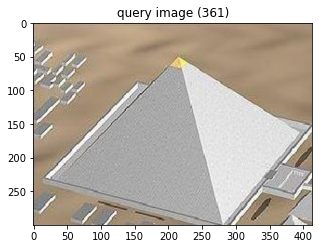

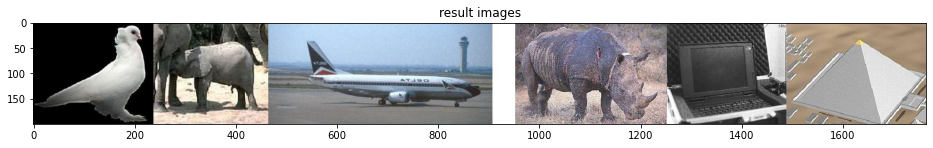

In [14]:
import matplotlib.pyplot as plt

query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(top_indices, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")